# Análisis exploratorio de datos exploratorios del Gran Premio de Fórmula 1 (EDA)
##  Exploratory Data Analysis (EDA)

## Exploratorio basado en los conductores, constructores o ambos
### Reglas de la FIA definidas en los últimos 10 años

Antes de comenzar el proyecto necesitamos entender la historia de la F1 y las diferentes épocas en las que un determinado piloto o equipo dominó toda la parrilla. Aquí hay algunas épocas importantes de la F1 en la historia (relativamente) reciente.

* 1994-2009 Schumacher (Scuderia Ferrari)
* 2007-2010 Alonso (Renault,Scuderia Ferrari)
* 2011-2013 Vettle (Redbull Racing)
* 2014-Present Hamilton (Mercedes-Benz)
* 2022 - Cambios

El rendimiento de un equipo de F1 depende en gran medida del reglamento técnico de la FIA para la temporada. Después de la temporada 2013, se hicieron nuevas regulaciones de motores (era híbrida). Mercedes-Benz es el equipo más dominante desde entonces, seguido de Red Bull Racing y Scuderia Ferrari. Las reglas cambiarán para 2022, por lo que cualquier análisis que se haga aquí no se aplicará para la temporada 2022 y después.

Sólo los datos posteriores a 2010 se considerarán en el siguiente análisis.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import time
start = time.time()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,precision_score,f1_score,recall_score
plt.style.use('seaborn')

In [4]:
results = pd.read_csv(r'./data_f1/results.csv')
races = pd.read_csv(r'./data_f1/races.csv')
quali = pd.read_csv(r'./data_f1/qualifying.csv')
drivers = pd.read_csv(r'./data_f1/drivers.csv')
constructors = pd.read_csv(r'./data_f1/constructors.csv')
circuit = pd.read_csv(r'./data_f1/circuits.csv')

In [5]:
df1 = pd.merge(races,results,how='inner',on=['raceId'])
df2 = pd.merge(df1,quali,how='inner',on=['raceId','driverId','constructorId'])
df3 = pd.merge(df2,drivers,how='inner',on=['driverId'])
df4 = pd.merge(df3,constructors,how='inner',on=['constructorId'])
df5 = pd.merge(df4,circuit,how='inner',on=['circuitId'])

In [6]:
df5.head()

,raceId,year,round,circuitId,name_x,date,time_x,url_x,resultId,driverId,...,nationality_y,url_x,circuitRef,name,location,country,lat,lng,alt,url_y
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,7554,18,...,British,http://en.wikipedia.org/wiki/Brawn_GP,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
1,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,7555,22,...,British,http://en.wikipedia.org/wiki/Brawn_GP,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
2,18,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...,18,18,...,Japanese,http://en.wikipedia.org/wiki/Honda_Racing_F1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
3,36,2007,1,1,Australian Grand Prix,2007-03-18,03:00:00,http://en.wikipedia.org/wiki/2007_Australian_G...,383,18,...,Japanese,http://en.wikipedia.org/wiki/Honda_Racing_F1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
4,55,2006,3,1,Australian Grand Prix,2006-04-02,14:00:00,http://en.wikipedia.org/wiki/2006_Australian_G...,796,18,...,Japanese,http://en.wikipedia.org/wiki/Honda_Racing_F1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...


In [7]:
list(df5.columns)

['raceId',
 'year',
 'round',
 'circuitId',
 'name_x',
 'date',
 'time_x',
 'url_x',
 'resultId',
 'driverId',
 'constructorId',
 'number_x',
 'grid',
 'position_x',
 'positionText',
 'positionOrder',
 'points',
 'laps',
 'time_y',
 'milliseconds',
 'fastestLap',
 'rank',
 'fastestLapTime',
 'fastestLapSpeed',
 'statusId',
 'qualifyId',
 'number_y',
 'position_y',
 'q1',
 'q2',
 'q3',
 'driverRef',
 'number',
 'code',
 'forename',
 'surname',
 'dob',
 'nationality_x',
 'url_y',
 'constructorRef',
 'name_y',
 'nationality_y',
 'url_x',
 'circuitRef',
 'name',
 'location',
 'country',
 'lat',
 'lng',
 'alt',
 'url_y']

In [8]:
#drop the columns which are not important
data = df5.drop(['round','circuitId','time_x','url_x','resultId','driverId',
                 'constructorId','number_x','positionText','position_x',
                 'positionOrder','laps','time_y','rank',
                 'fastestLapTime','fastestLapSpeed','qualifyId','driverRef','number','code','url_y','circuitRef',
                 'location','lat','lng','alt','number_y','points','constructorRef','name_x','raceId','fastestLap','q2','q3','milliseconds','q1'],1)

In [9]:
list(data.columns)

['year',
 'date',
 'grid',
 'statusId',
 'position_y',
 'forename',
 'surname',
 'dob',
 'nationality_x',
 'name_y',
 'nationality_y',
 'name',
 'country']

## Hypotesis

Buscamos los 5 conductores que podrian ganar una carrera.

![](./docs/hyp.png)

## Estructura del Gran Premio de F1

Un Gran Premio de F1 se extiende durante 3 días durante el fin de semana, y se compone de 3 partes: sesión de práctica, sesión de clasificación y la carrera real.

En la sesión de prácticas hay 3 etapas: FP1, FP2 y FP3. Esta es una sesión de entrenamientos libres para que los equipos prueben sus autos el viernes y el sábado.

Las rondas de clasificación también comprenden 3 etapas: Q1, Q2 y Q3. En esta sesión, todos los pilotos compiten para establecer el mejor tiempo de vuelta. Los 5 últimos pilotos serán eliminados después de la Q1; los 15 mejores pilotos participarán en la Q2 e intentarán establecer el mejor tiempo de vuelta. Los 10 mejores pilotos pasarán a la Q3, donde volverán a competir para establecer el mejor tiempo de vuelta. Las posiciones de salida de los coches se decidirán en función de su tiempo de calificación. El piloto con el mejor tiempo podrá comenzar en la parte delantera.

El domingo es la carrera, y se otorgarán puntos a los 10 mejores pilotos. Los tres primeros podrán disfrutar del podio.

Esto sucede durante una temporada completa, durante todo un año, en diferentes circuitos. El piloto con los puntos más altos recibirá el campeonato mundial, y el equipo con el punto más alto obtendrá el campeonato por equipos (cada equipo tiene dos autos y dos pilotos).

In [10]:
#considering data points from 2010
data = data[data['year']>=2010]

In [11]:
#rename the columns
data.rename(columns={'name':'GP_name','position_y':'position','grid':'quali_pos','name_y':'constructor','nationality_x':'driver_nationality','nationality_y':'constructor_nationality'},inplace=True)
data['driver'] = data['forename']+' '+data['surname']
data['date'] = pd.to_datetime(data['date'])
data['dob'] = pd.to_datetime(data['dob'])

In [12]:
#creating a driver age parameter
data['age_at_gp_in_days'] = abs(data['dob']-data['date'])
data['age_at_gp_in_days'] = data['age_at_gp_in_days'].apply(lambda x: str(x).split(' ')[0])

## Limpieza del conjunto de datos


In [13]:
# Algunos de los constructores cambiaron su nombre a lo largo del año, por lo que reemplazaron los nombres antiguos con el nombre actual.

data['constructor'] = data['constructor'].apply(lambda x: 'Aston Martin' if x=='Force India' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Aston Martin' if x=='Racing Point' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alfa Romeo' if x=='Sauber' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alpine F1' if x=='Lotus F1' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alpine F1' if x=='Renault' else x)
# Corrección para 2021

data['constructor'] = data['constructor'].apply(lambda x: 'Alpine F1' if x=='Alpine F1 Team' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'AlphaTauri' if x=='Toro Rosso' else x)

In [14]:
data['driver_nationality'] = data['driver_nationality'].apply(lambda x: str(x)[:3])
data['constructor_nationality'] = data['constructor_nationality'].apply(lambda x: str(x)[:3])
data['country'] = data['country'].apply(lambda x: 'Bri' if x=='UK' else x)
data['country'] = data['country'].apply(lambda x: 'Ame' if x=='USA' else x)
data['country'] = data['country'].apply(lambda x: 'Fre' if x=='Fra' else x)
data['country'] = data['country'].apply(lambda x: str(x)[:3])
data['driver_home'] = data['driver_nationality'] == data['country']
data['constructor_home'] = data['constructor_nationality'] == data['country']
data['driver_home'] = data['driver_home'].apply(lambda x: int(x))
data['constructor_home'] = data['constructor_home'].apply(lambda x: int(x))

In [15]:
#razones para DNF(no terminó)
#reasons for DNF(did not finish)
data['driver_dnf'] = data['statusId'].apply(lambda x: 1 if x in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137] else 0)
data['constructor_dnf'] = data['statusId'].apply(lambda x: 1 if x not in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137,1] else 0)
data.drop(['forename','surname'],1,inplace=True)

In [16]:
font = {
    'family':'serif',
    'color':'black',
    'weight':'bold',
    'size':10
}

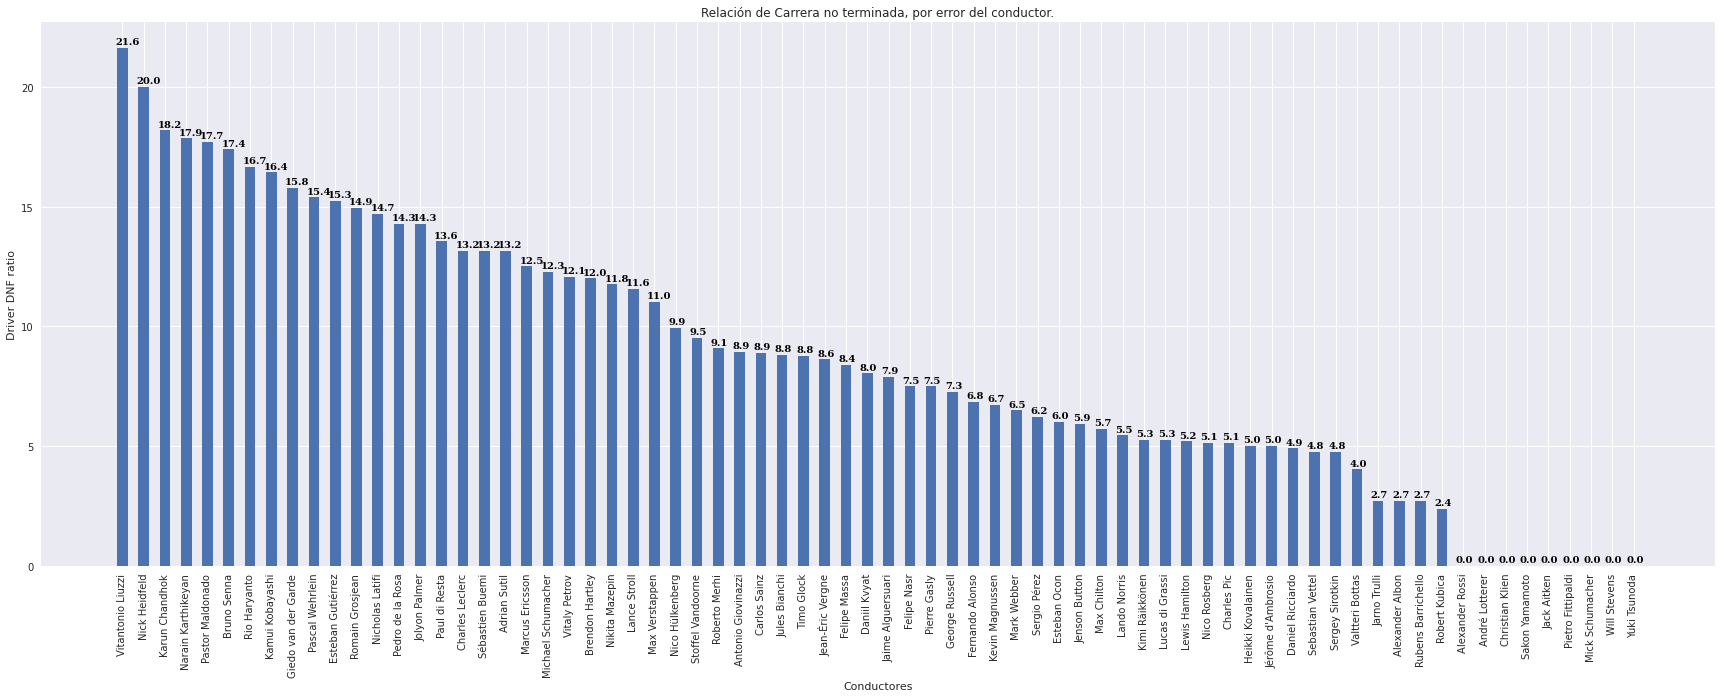

In [17]:
dnf_by_driver = data.groupby('driver').sum()['driver_dnf']
driver_race_entered = data.groupby('driver').count()['driver_dnf']
driver_dnf_ratio = (dnf_by_driver*100/driver_race_entered).sort_values(ascending=False)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_dnf_ratio.index,height=driver_dnf_ratio,align='center',width=0.5)
plt.xticks(rotation=90)
plt.xlabel('Conductores')
plt.ylabel('Driver DNF ratio')
plt.title('Relación de Carrera no terminada, por error del conductor.')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()-0.1,yval+0.15,f'{round(yval,1)}',fontdict=font)
plt.show()

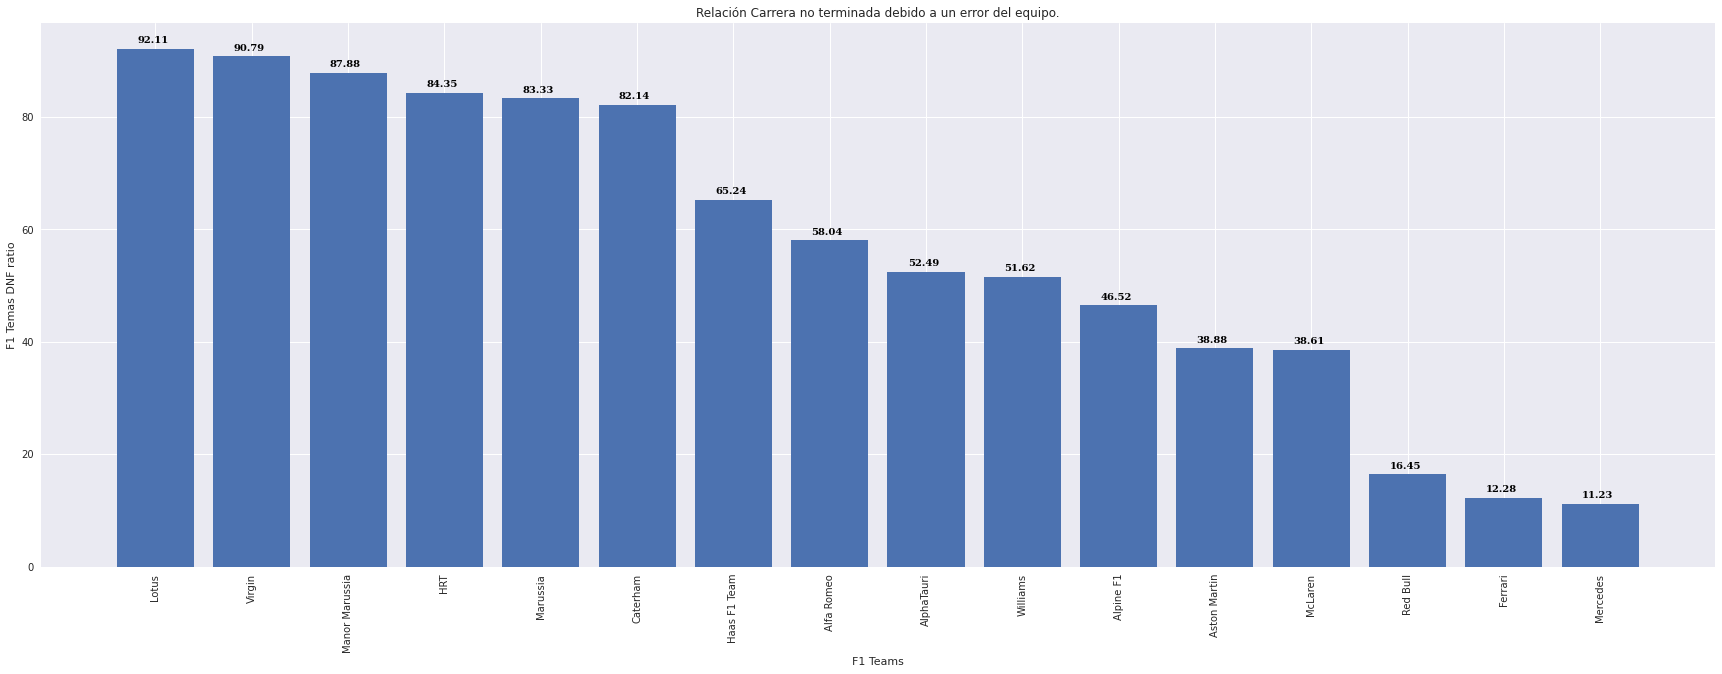

In [18]:
dnf_by_constructor = data.groupby('constructor').sum()['constructor_dnf']
constructor_race_entered = data.groupby('constructor').count()['constructor_dnf']
constructor_dnf_ratio = (dnf_by_constructor*100/constructor_race_entered).sort_values(ascending=False)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_dnf_ratio.index,height=constructor_dnf_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('F1 Teams')
plt.ylabel('F1 Temas DNF ratio')
plt.title('Relación Carrera no terminada debido a un error del equipo.')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.21,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

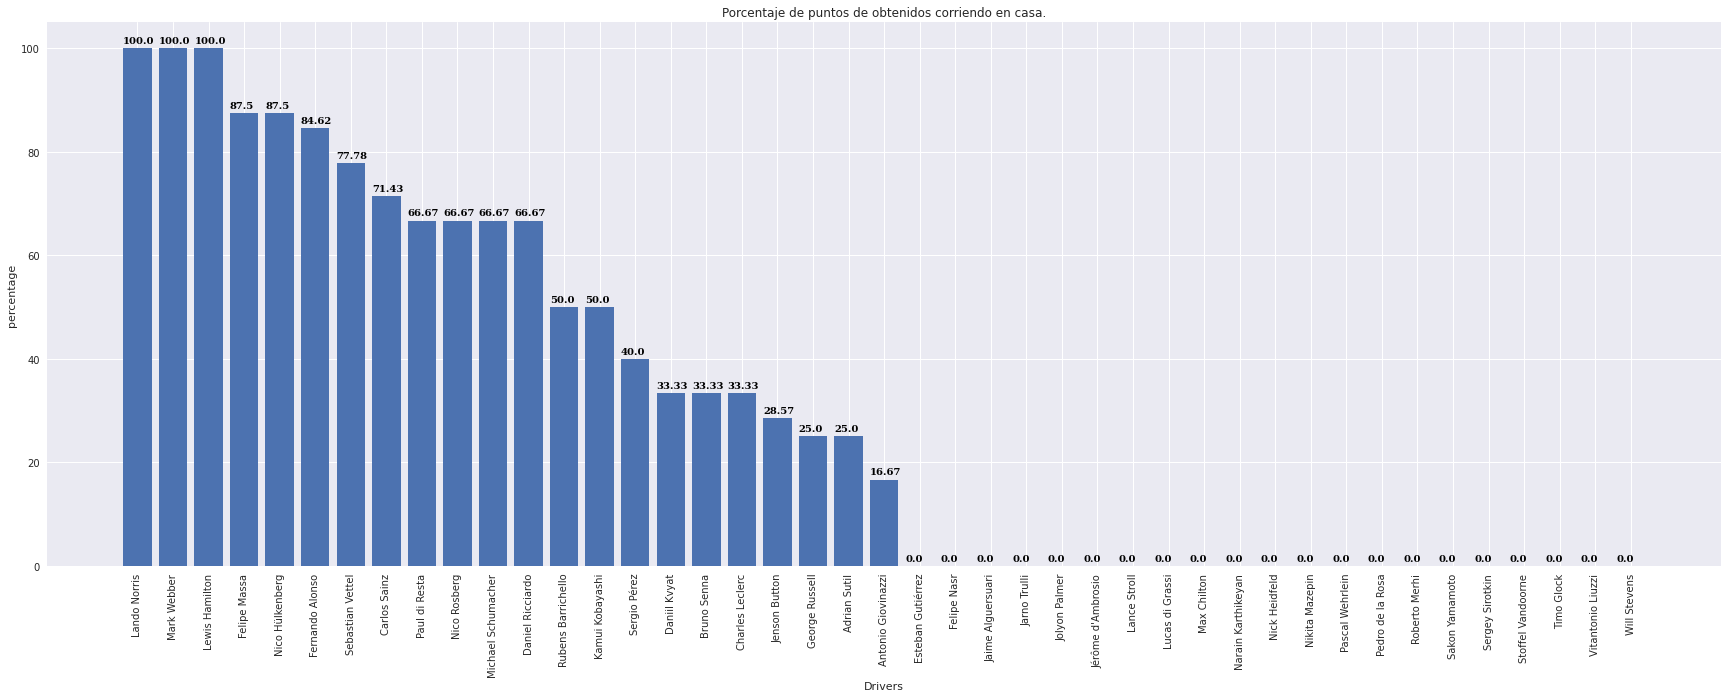

In [19]:
driver_home_points_finish = data.loc[(data['position']<11)&(data['driver_home']==1)].groupby('driver').count()['position']
total_home_races = data[data['driver_home']==1].groupby('driver').sum()['driver_home']
driver_home_point_finish_ratio = (driver_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_home_point_finish_ratio.index,height=driver_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Drivers')
plt.ylabel('percentage')
plt.title('Porcentaje de puntos de obtenidos corriendo en casa.')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x(),yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

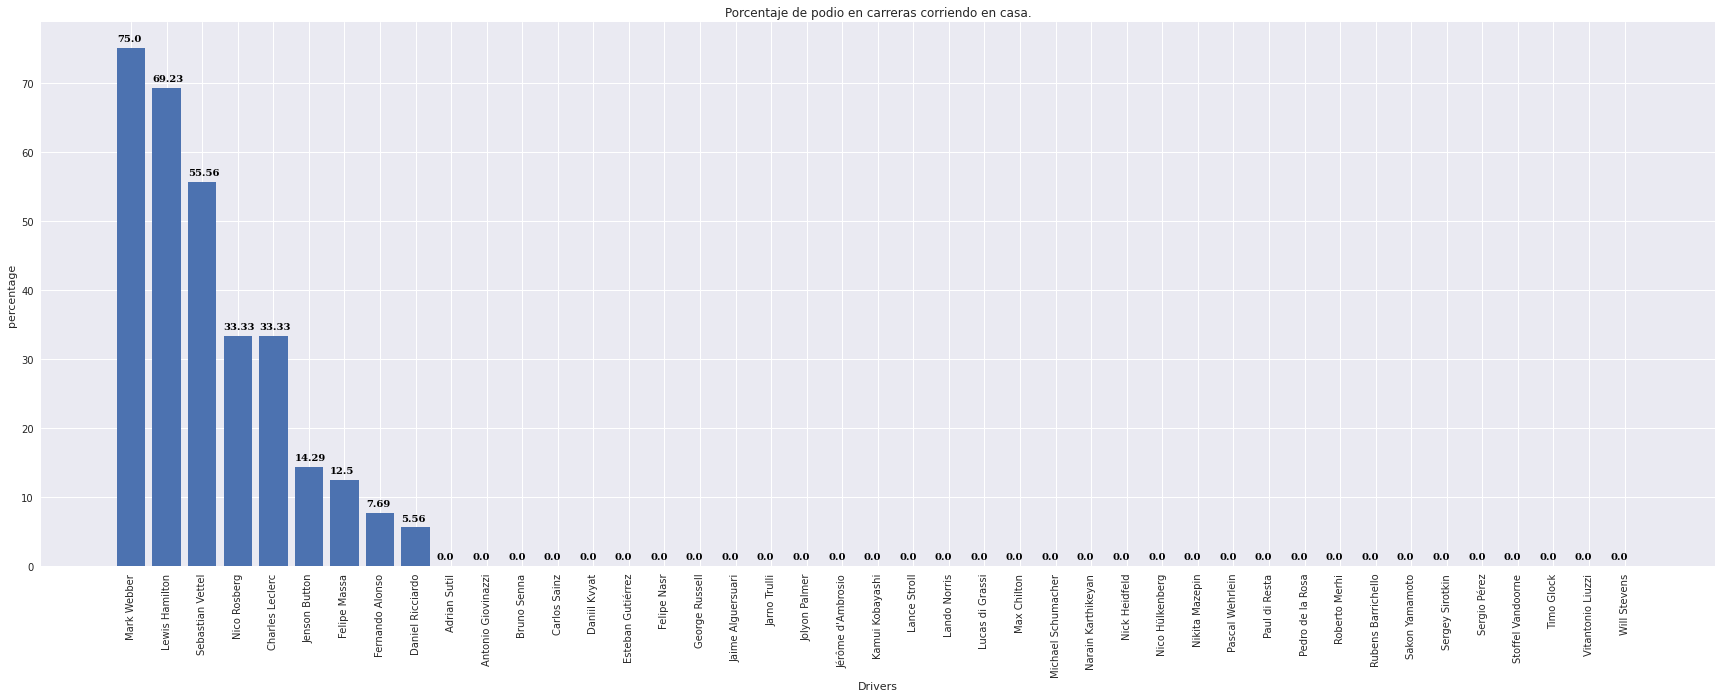

In [20]:
driver_home_podium_finish = data.loc[(data['position']<4)&(data['driver_home']==1)].groupby('driver').count()['position']
total_home_races = data[data['driver_home']==1].groupby('driver').sum()['driver_home']
driver_home_podium_finish_ratio = (driver_home_podium_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_home_podium_finish_ratio.index,height=driver_home_podium_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Drivers')
plt.ylabel('percentage')
plt.title('Porcentaje de podio en carreras corriendo en casa.')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x(),yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

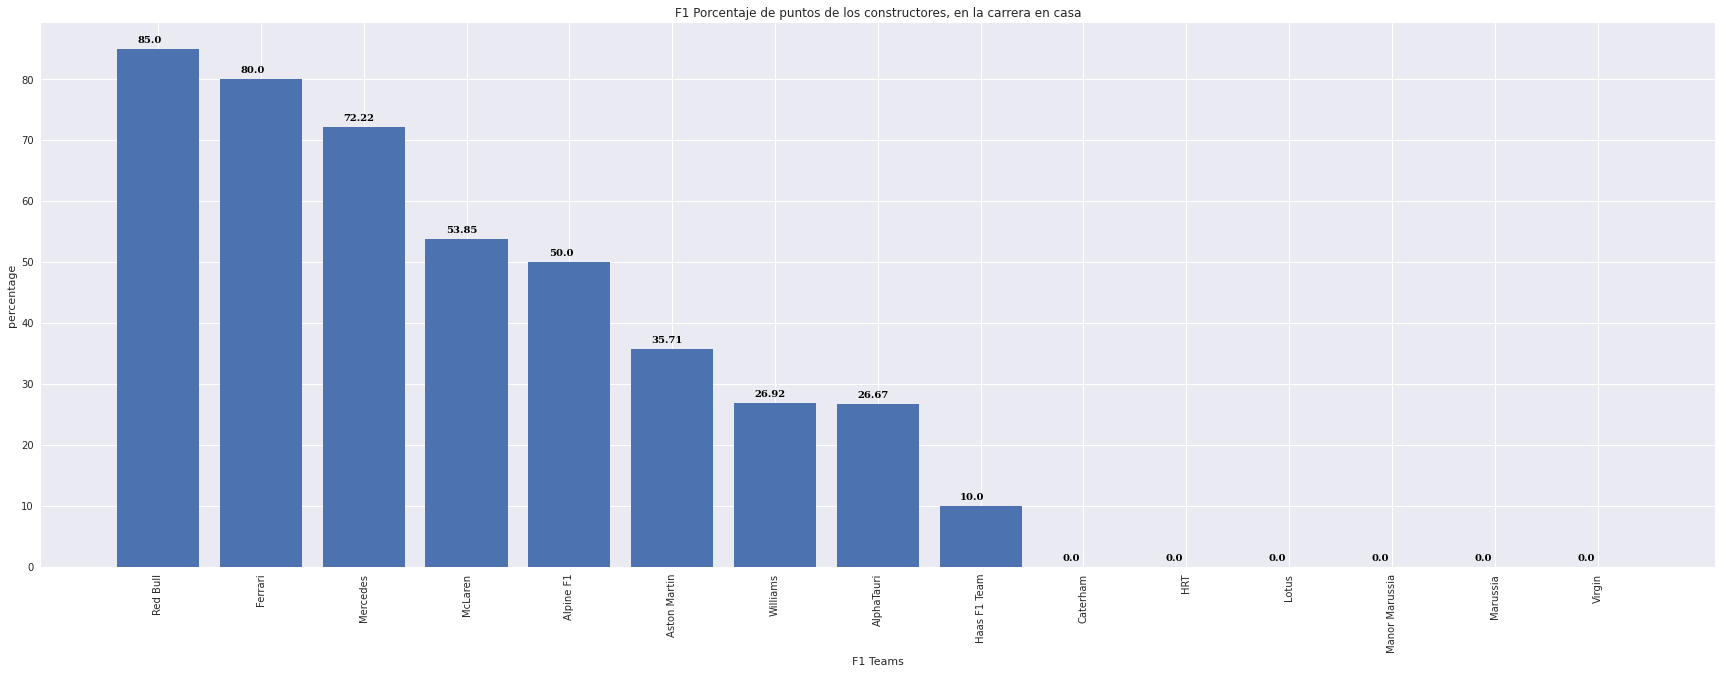

In [21]:
constructor_home_points_finish = data.loc[(data['position']<11)&(data['constructor_home']==1)].groupby('constructor').count()['position']
total_home_races = data[data['constructor_home']==1].groupby('constructor').sum()['constructor_home']
constructor_home_point_finish_ratio = (constructor_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_home_point_finish_ratio.index,height=constructor_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('F1 Teams')
plt.ylabel('percentage')
plt.title('F1 Porcentaje de puntos de los constructores, en la carrera en casa')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

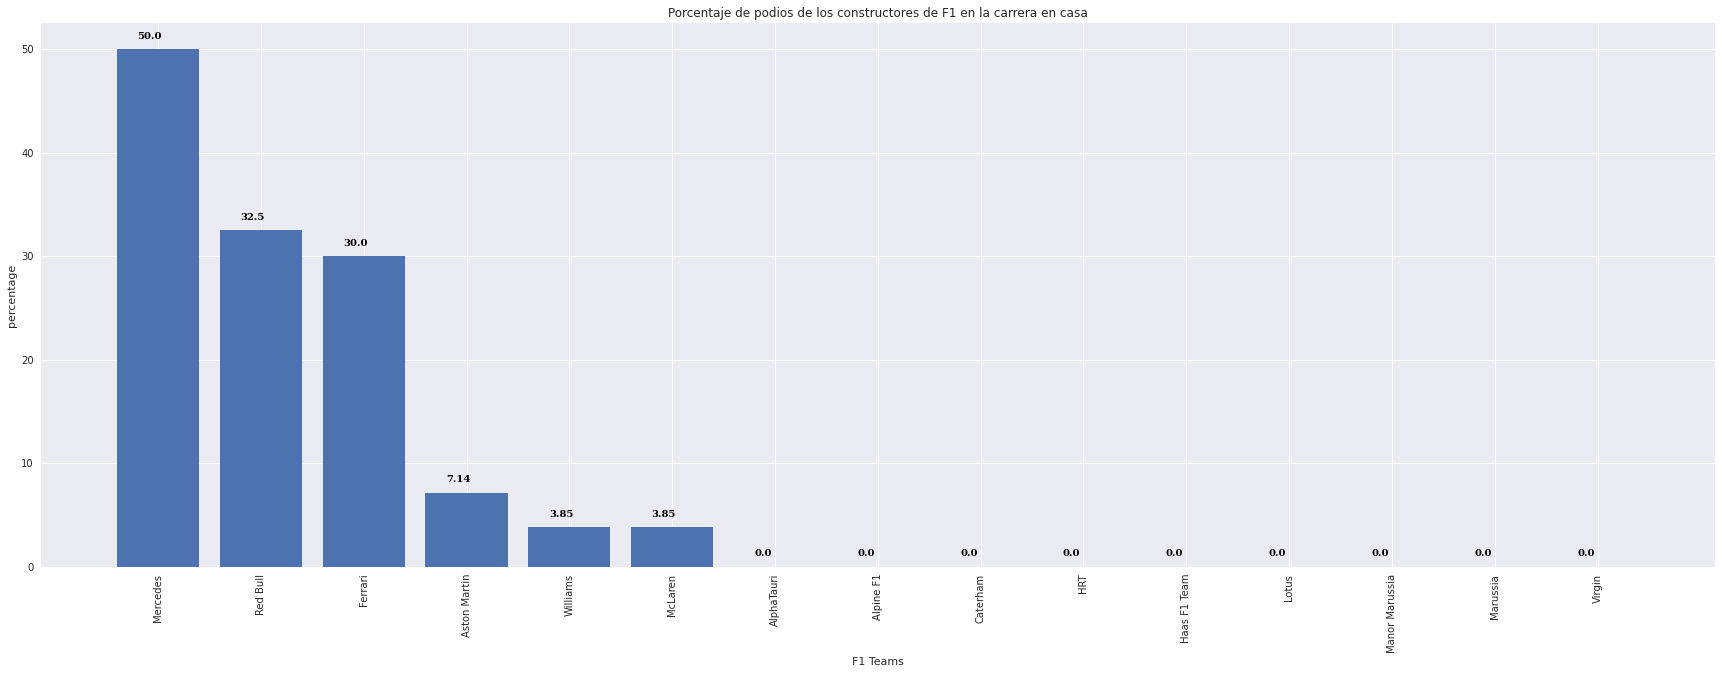

In [22]:
constructor_home_points_finish = data.loc[(data['position']<4)&(data['constructor_home']==1)].groupby('constructor').count()['position']
total_home_races = data[data['constructor_home']==1].groupby('constructor').sum()['constructor_home']
constructor_home_point_finish_ratio = (constructor_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_home_point_finish_ratio.index,height=constructor_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('F1 Teams')
plt.ylabel('percentage')
plt.title('Porcentaje de podios de los constructores de F1 en la carrera en casa')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

In [23]:
data.head()

,year,date,quali_pos,statusId,position,dob,driver_nationality,constructor,constructor_nationality,GP_name,country,driver,age_at_gp_in_days,driver_home,constructor_home,driver_dnf,constructor_dnf
26,2011,2011-03-27,18,11,18,1977-05-10,Ger,Alpine F1,Fre,Albert Park Grand Prix Circuit,Aus,Nick Heidfeld,12374,0,0,0,1
30,2010,2010-03-28,9,1,9,1984-12-07,Pol,Alpine F1,Fre,Albert Park Grand Prix Circuit,Aus,Robert Kubica,9242,0,0,0,0
34,2017,2017-03-26,11,11,12,1987-08-19,Ger,Alpine F1,Fre,Albert Park Grand Prix Circuit,Aus,Nico Hülkenberg,10812,0,0,0,1
35,2018,2018-03-25,7,1,8,1987-08-19,Ger,Alpine F1,Fre,Albert Park Grand Prix Circuit,Aus,Nico Hülkenberg,11176,0,0,0,0
36,2019,2019-03-17,11,11,11,1987-08-19,Ger,Alpine F1,Fre,Albert Park Grand Prix Circuit,Aus,Nico Hülkenberg,11533,0,0,0,1


In [24]:
data.to_csv('./data_f1/data_filtered.csv', index = False)

## Analysis dataset only for 2021

In [25]:
data2021 = df5[df5['year']==2021]

In [26]:
print(data2021)

      raceId  year  round  circuitId              name_x        date  \
1224    1052  2021      1          3  Bahrain Grand Prix  2021-03-28   
1227    1052  2021      1          3  Bahrain Grand Prix  2021-03-28   
1252    1052  2021      1          3  Bahrain Grand Prix  2021-03-28   
1263    1052  2021      1          3  Bahrain Grand Prix  2021-03-28   
1295    1052  2021      1          3  Bahrain Grand Prix  2021-03-28   
...      ...   ...    ...        ...                 ...         ...   
9020    1064  2021     13         39    Dutch Grand Prix  2021-09-05   
9021    1064  2021     13         39    Dutch Grand Prix  2021-09-05   
9022    1064  2021     13         39    Dutch Grand Prix  2021-09-05   
9023    1064  2021     13         39    Dutch Grand Prix  2021-09-05   
9024    1064  2021     13         39    Dutch Grand Prix  2021-09-05   

        time_x                                              url_x  resultId  \
1224  15:00:00  https://en.wikipedia.org/wiki/2021_Bahra

In [27]:
#reasons for DNF(did not finish)
data2021['driver_dnf'] = data2021['statusId'].apply(lambda x: 1 if x in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137] else 0)
data2021['constructor_dnf'] = data2021['statusId'].apply(lambda x: 1 if x not in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137,1] else 0)

In [28]:
list(data2021.columns)

['raceId',
 'year',
 'round',
 'circuitId',
 'name_x',
 'date',
 'time_x',
 'url_x',
 'resultId',
 'driverId',
 'constructorId',
 'number_x',
 'grid',
 'position_x',
 'positionText',
 'positionOrder',
 'points',
 'laps',
 'time_y',
 'milliseconds',
 'fastestLap',
 'rank',
 'fastestLapTime',
 'fastestLapSpeed',
 'statusId',
 'qualifyId',
 'number_y',
 'position_y',
 'q1',
 'q2',
 'q3',
 'driverRef',
 'number',
 'code',
 'forename',
 'surname',
 'dob',
 'nationality_x',
 'url_y',
 'constructorRef',
 'name_y',
 'nationality_y',
 'url_x',
 'circuitRef',
 'name',
 'location',
 'country',
 'lat',
 'lng',
 'alt',
 'url_y',
 'driver_dnf',
 'constructor_dnf']

In [29]:
#rename the columns
data2021.rename(columns={'name':'GP_name','position_y':'position','grid':'quali_pos','name_y':'constructor','nationality_x':'driver_nationality','nationality_y':'constructor_nationality'},inplace=True)
data2021['driver'] = data2021['forename']+' '+data2021['surname']
data2021['date'] = pd.to_datetime(data2021['date'])
data2021['dob'] = pd.to_datetime(data2021['dob'])

In [30]:
#Algunos de los constructores cambiaron su nombre a lo largo del año, por lo que reemplazaron los nombres antiguos con el nombre actual.

data2021['constructor'] = data2021['constructor'].apply(lambda x: 'Aston Martin' if x=='Force India' else x)
data2021['constructor'] = data2021['constructor'].apply(lambda x: 'Aston Martin' if x=='Racing Point' else x)
data2021['constructor'] = data2021['constructor'].apply(lambda x: 'Alfa Romeo' if x=='Sauber' else x)
data2021['constructor'] = data2021['constructor'].apply(lambda x: 'Alpine F1' if x=='Lotus F1' else x)
data2021['constructor'] = data2021['constructor'].apply(lambda x: 'Alpine F1' if x=='Renault' else x)
data2021['constructor'] = data2021['constructor'].apply(lambda x: 'Alpine F1' if x=='Alpine F1 Team' else x)
data2021['constructor'] = data2021['constructor'].apply(lambda x: 'AlphaTauri' if x=='Toro Rosso' else x)

In [31]:
data2021['driver_nationality'] = data2021['driver_nationality'].apply(lambda x: str(x)[:3])
data2021['constructor_nationality'] = data2021['constructor_nationality'].apply(lambda x: str(x)[:3])
data2021['country'] = data2021['country'].apply(lambda x: 'Bri' if x=='UK' else x)
data2021['country'] = data2021['country'].apply(lambda x: 'Ame' if x=='USA' else x)
data2021['country'] = data2021['country'].apply(lambda x: 'Fre' if x=='Fra' else x)
data2021['country'] = data2021['country'].apply(lambda x: str(x)[:3])
data2021['driver_home'] = data2021['driver_nationality'] == data2021['country']
data2021['constructor_home'] = data2021['constructor_nationality'] == data2021['country']
data2021['driver_home'] = data2021['driver_home'].apply(lambda x: int(x))
data2021['constructor_home'] = data2021['constructor_home'].apply(lambda x: int(x))

In [32]:
data2021.to_csv('./data_f1/data_filtered_2021.csv', index = False)

In [33]:
data2021

,raceId,year,round,circuitId,name_x,date,time_x,url_x,resultId,driverId,...,country,lat,lng,alt,url_y,driver_dnf,constructor_dnf,driver,driver_home,constructor_home
1224,1052,2021,1,3,Bahrain Grand Prix,2021-03-28,15:00:00,https://en.wikipedia.org/wiki/2021_Bahrain_Gra...,24979,847,...,Bah,26.0325,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_Internati...,0,1,George Russell,0,0
1227,1052,2021,1,3,Bahrain Grand Prix,2021-03-28,15:00:00,https://en.wikipedia.org/wiki/2021_Bahrain_Gra...,24983,849,...,Bah,26.0325,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_Internati...,1,0,Nicholas Latifi,0,0
1252,1052,2021,1,3,Bahrain Grand Prix,2021-03-28,15:00:00,https://en.wikipedia.org/wiki/2021_Bahrain_Gra...,24972,817,...,Bah,26.0325,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_Internati...,0,0,Daniel Ricciardo,0,0
1263,1052,2021,1,3,Bahrain Grand Prix,2021-03-28,15:00:00,https://en.wikipedia.org/wiki/2021_Bahrain_Gra...,24969,846,...,Bah,26.0325,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_Internati...,0,0,Lando Norris,0,0
1295,1052,2021,1,3,Bahrain Grand Prix,2021-03-28,15:00:00,https://en.wikipedia.org/wiki/2021_Bahrain_Gra...,24973,832,...,Bah,26.0325,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_Internati...,0,0,Carlos Sainz,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9020,1064,2021,13,39,Dutch Grand Prix,2021-09-05,13:00:00,http://en.wikipedia.org/wiki/2021_Dutch_Grand_...,25219,841,...,Net,52.3888,4.54092,6,http://en.wikipedia.org/wiki/Circuit_Zandvoort,0,1,Antonio Giovinazzi,0,0
9021,1064,2021,13,39,Dutch Grand Prix,2021-09-05,13:00:00,http://en.wikipedia.org/wiki/2021_Dutch_Grand_...,25223,854,...,Net,52.3888,4.54092,6,http://en.wikipedia.org/wiki/Circuit_Zandvoort,0,1,Mick Schumacher,0,0
9022,1064,2021,13,39,Dutch Grand Prix,2021-09-05,13:00:00,http://en.wikipedia.org/wiki/2021_Dutch_Grand_...,25225,853,...,Net,52.3888,4.54092,6,http://en.wikipedia.org/wiki/Circuit_Zandvoort,0,1,Nikita Mazepin,0,0
9023,1064,2021,13,39,Dutch Grand Prix,2021-09-05,13:00:00,http://en.wikipedia.org/wiki/2021_Dutch_Grand_...,25209,842,...,Net,52.3888,4.54092,6,http://en.wikipedia.org/wiki/Circuit_Zandvoort,0,1,Pierre Gasly,0,0


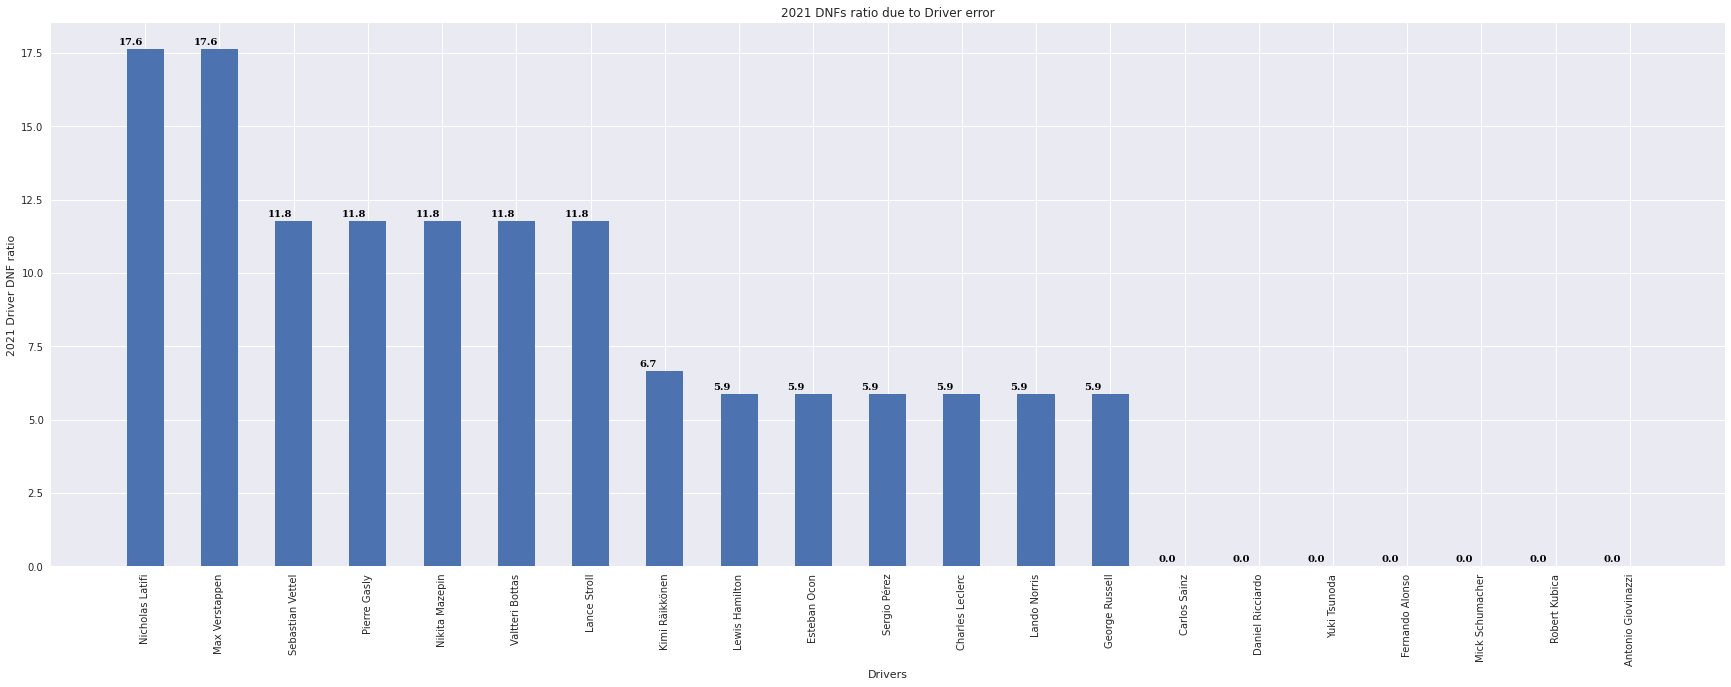

In [34]:
dnf_by_driver = data2021.groupby('driver').sum()['driver_dnf']
driver_race_entered = data2021.groupby('driver').count()['driver_dnf']
driver_dnf_ratio = (dnf_by_driver*100/driver_race_entered).sort_values(ascending=False)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_dnf_ratio.index,height=driver_dnf_ratio,align='center',width=0.5)
plt.xticks(rotation=90)
plt.xlabel('Drivers')
plt.ylabel('2021 Driver DNF ratio')
plt.title('2021 DNFs ratio due to Driver error')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()-0.1,yval+0.15,f'{round(yval,1)}',fontdict=font)
plt.show()

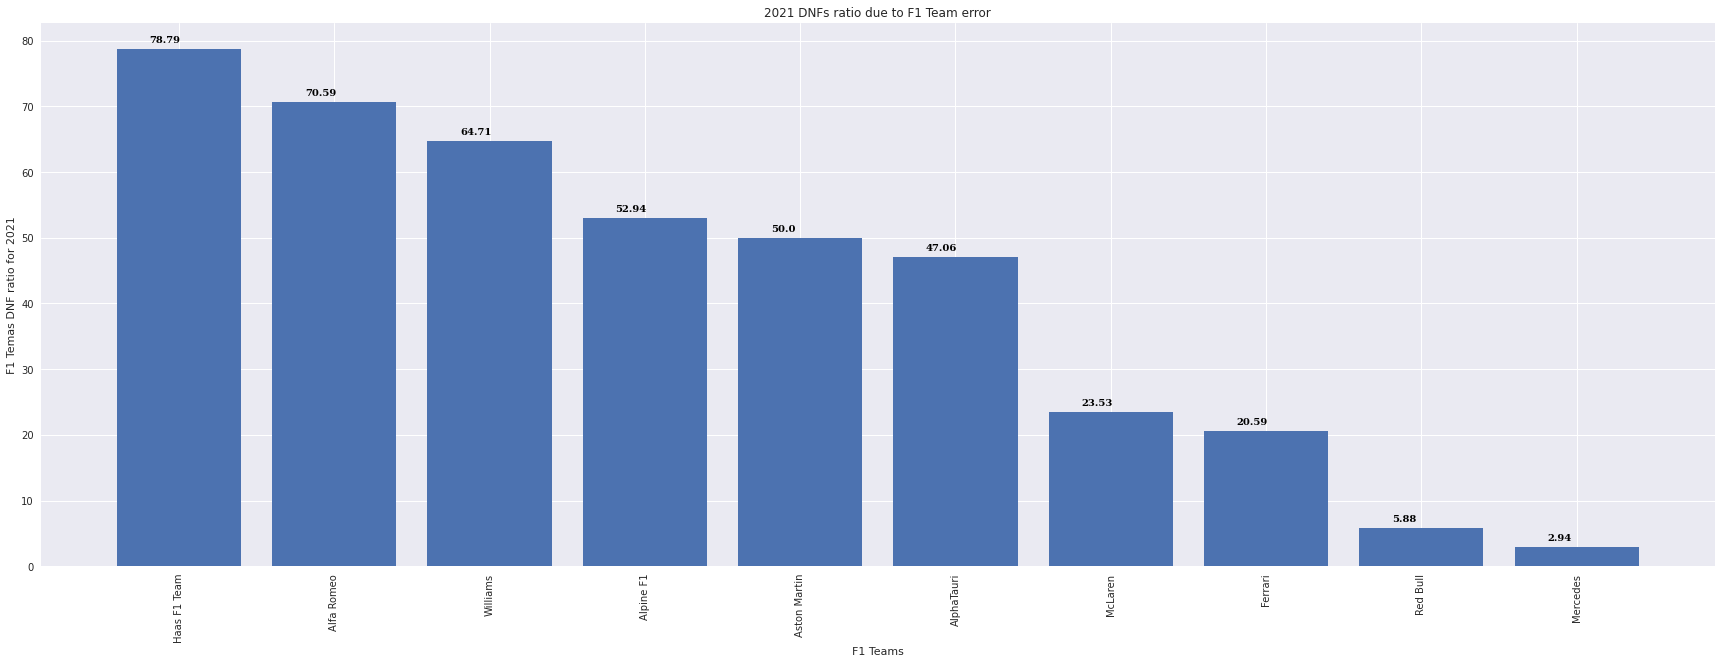

In [35]:
dnf_by_constructor = data2021.groupby('constructor').sum()['constructor_dnf']
constructor_race_entered = data2021.groupby('constructor').count()['constructor_dnf']
constructor_dnf_ratio = (dnf_by_constructor*100/constructor_race_entered).sort_values(ascending=False)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_dnf_ratio.index,height=constructor_dnf_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('F1 Teams')
plt.ylabel('F1 Temas DNF ratio for 2021')
plt.title('2021 DNFs ratio due to F1 Team error')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.21,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

# Check Points

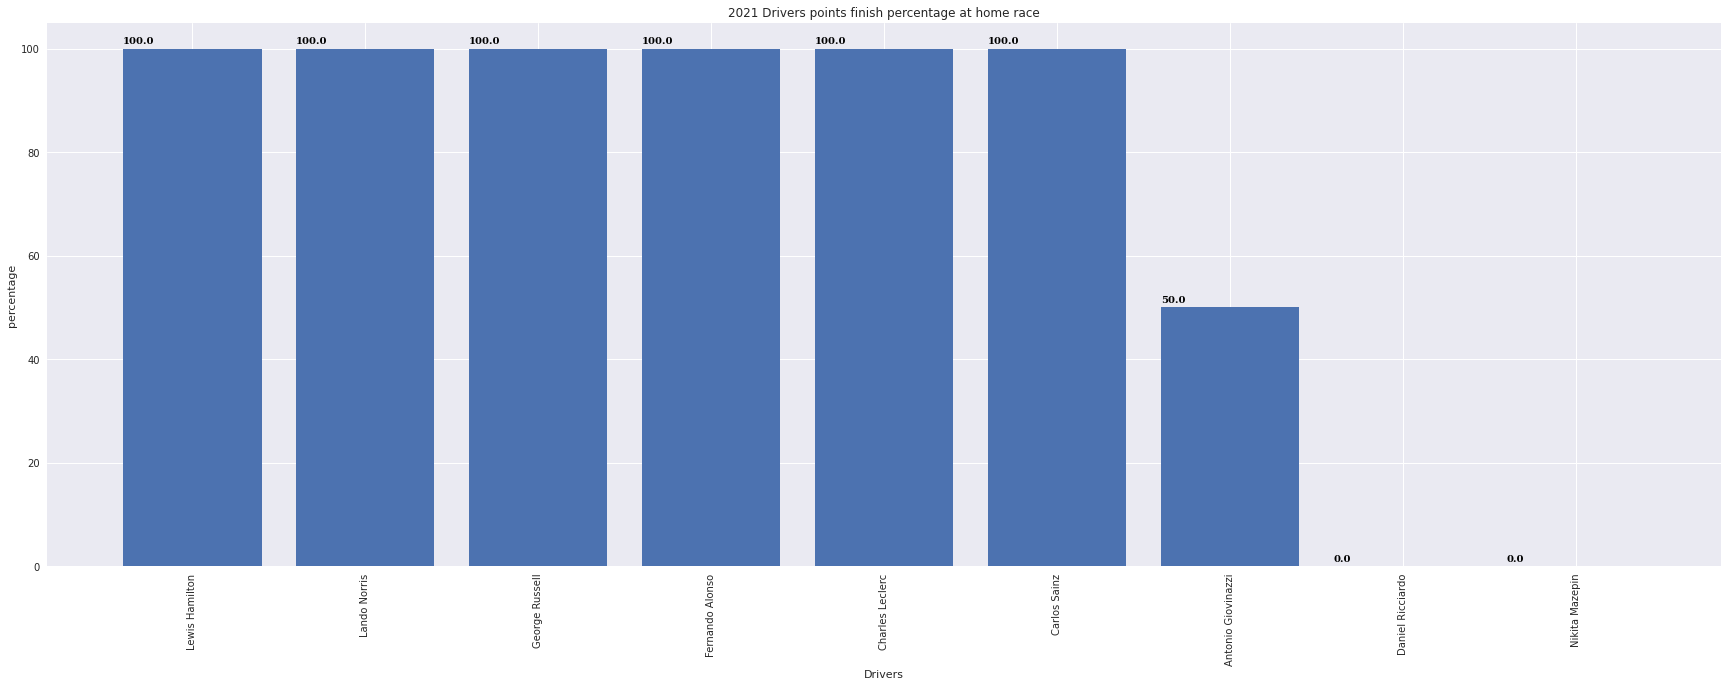

In [36]:
driver_home_points_finish = data2021.loc[(data2021['position']<11)&(data2021['driver_home']==1)].groupby('driver').count()['position']
total_home_races = data2021[data2021['driver_home']==1].groupby('driver').sum()['driver_home']
driver_home_point_finish_ratio = (driver_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_home_point_finish_ratio.index,height=driver_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Drivers')
plt.ylabel('percentage')
plt.title('2021 Drivers points finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x(),yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

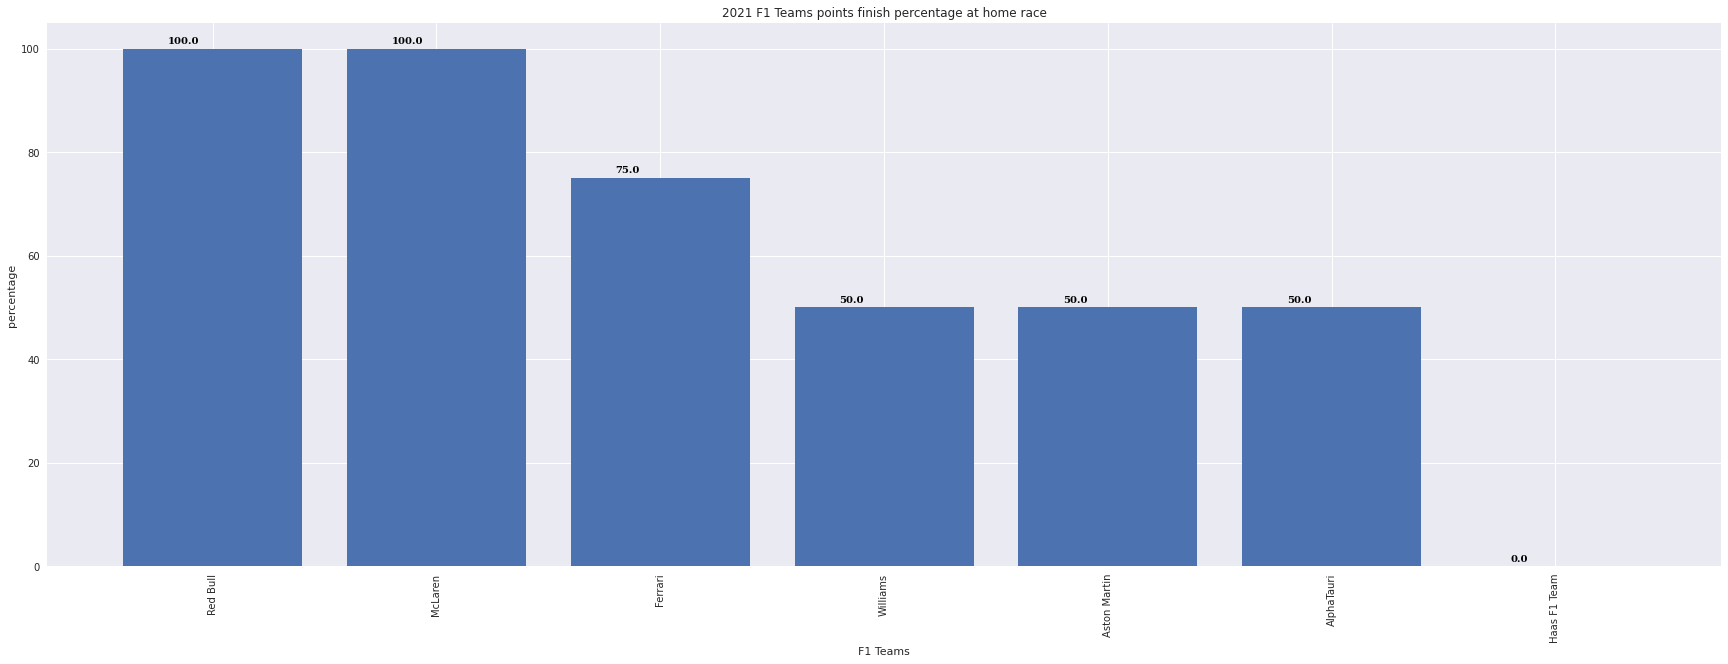

In [37]:
constructor_home_points_finish = data2021.loc[(data2021['position']<11)&(data2021['constructor_home']==1)].groupby('constructor').count()['position']
total_home_races = data2021[data2021['constructor_home']==1].groupby('constructor').sum()['constructor_home']
constructor_home_point_finish_ratio = (constructor_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_home_point_finish_ratio.index,height=constructor_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('F1 Teams')
plt.ylabel('percentage')
plt.title('2021 F1 Teams points finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

In [38]:
end = time.time()

In [39]:
import datetime
str(datetime.timedelta(seconds=(end - start)))

'0:00:14.414106'

In [40]:
print(str(end - start)+" seconds")

14.414106130599976 seconds
